In [7]:
import numpy as np
import cv2
import os
import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from matplotlib import pyplot as plt

In [8]:
np.random.seed(1000)
os.environ['KERAS_BACKEND'] = 'tensorflow'

Read and resize

In [9]:
image_directory = "F:/JU PROJECTS/First try project on Images RS/Covid_Dataset/"
SIZE = 64
dataset = []
label = []

covid_positive = os.listdir(image_directory + 'CT_COVID/')
for i, img_name in enumerate(covid_positive):
    image = cv2.imread(image_directory + 'CT_COVID/' + img_name)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((SIZE, SIZE))
    dataset.append(np.array(image))
    label.append(0)

covid_negative = os.listdir(image_directory + 'CT_NonCOVID/')
for i, img_name in enumerate(covid_negative):
    image = cv2.imread(image_directory + 'CT_NonCOVID/' + img_name)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((SIZE, SIZE))
    dataset.append(np.array(image))
    label.append(1)

Model

In [10]:
INPUT_SHAPE = (SIZE, SIZE, 3)   
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                            activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)

conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                            activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.
hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='categorical_crossentropy',   #Check between binary_crossentropy and categorical_crossentropy
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248  

Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)

Fit model

In [12]:
history = model.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 10, 
                         verbose = 1, 
                         epochs = 10,      #Changed to 3 from 50 for testing purposes.
                         validation_split = 0.2,
                         shuffle = False
                      #   callbacks=callbacks
                     )
print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

Epoch 1/10
48/48 [==============================] - 8s 130ms/step - loss: 0.8850 - accuracy: 0.6736 - val_loss: 14.4329 - val_accuracy: 0.5167
Epoch 2/10
48/48 [==============================] - 6s 126ms/step - loss: 0.4409 - accuracy: 0.8075 - val_loss: 3.8171 - val_accuracy: 0.5667
Epoch 3/10
48/48 [==============================] - 6s 126ms/step - loss: 0.3005 - accuracy: 0.8745 - val_loss: 2.0345 - val_accuracy: 0.5917
Epoch 4/10
48/48 [==============================] - 6s 127ms/step - loss: 0.2129 - accuracy: 0.9100 - val_loss: 0.5563 - val_accuracy: 0.8083
Epoch 5/10
48/48 [==============================] - 6s 123ms/step - loss: 0.1530 - accuracy: 0.9456 - val_loss: 1.3517 - val_accuracy: 0.6667
Epoch 6/10
48/48 [==============================] - 6s 123ms/step - loss: 0.1285 - accuracy: 0.9582 - val_loss: 0.9983 - val_accuracy: 0.7000
Epoch 7/10
48/48 [==============================] - 6s 118ms/step - loss: 0.1005 - accuracy: 0.9582 - val_loss: 1.2954 - val_accuracy: 0.6750
Epoch

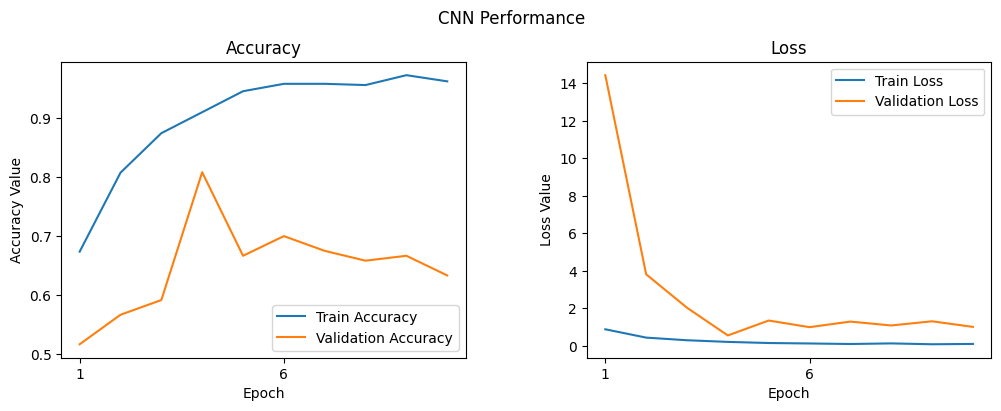

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [14]:
model.save('covid_cnn_res.hs')

INFO:tensorflow:Assets written to: covid_cnn_res.hs\assets


INFO:tensorflow:Assets written to: covid_cnn_res.hs\assets
